#### Stock Price Prediction Using Long-Short-Term-Model Algorithm in Neural Networks 
 Developers
+ 214210050 Furkan Demircan
+ 214210056 Eray Elagoz 
---------------------------------------------------------------------------

##### Objective
It aims to leverage machine learning & Deep Learning techniques to develop an accurate and reliable model for predicting and forecasting Bitcoin prices. By utilizing historical data and relevant features, the model provided insights into the potential future trends of Bitcoin, assisting investors, traders, and researchers in making informed decisions in the cryptocurrency market.

#### Libraries

In [1]:
# Data manipulation and analysis
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # data visualization
import yfinance as yf # for coin data

# Main libraries
import datetime as dt # for date and time operations
import time

# Machine learning
from sklearn.preprocessing import MinMaxScaler # for normalization
from sklearn.metrics import mean_squared_error, mean_absolute_error,root_mean_squared_error, mean_absolute_percentage_error # for model evaluation
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, r2_score # for model evaluation

# Deep learning
import tensorflow as tf # For neural networks
from tensorflow.keras.models import Sequential # For building the neural network
from tensorflow.keras.layers import Dense, Dropout, LSTM # For building neural networks
from tensorflow.keras.optimizers import Adam # For configuring the learning process
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # Callbacks for the neural network

#### Fetching The Data

In [2]:
# Data manipulation and analysis
stocks = ['AMZN', 'GOOGL', 'TSLA', 'AAPL']
start_date = "2016-01-01"
end_date = "2024-11-01"

# Get the data
stock_data = {ticker: yf.download(ticker, start=start_date, end=end_date)['Close'] for ticker in stocks}

# Combine the data
combined_data = pd.concat(stock_data.values(), axis=1, keys=stock_data.keys()).dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


##### Combined Data Table

In [3]:
# Display the first few rows of the data
combined_data.head()

,AMZN,GOOGL,TSLA,AAPL
Ticker,AMZN,GOOGL,TSLA,AAPL
Date,,,,
2016-01-04,31.849501,37.972000,14.894000,26.337500
2016-01-05,31.689501,38.076500,14.895333,25.677500
2016-01-06,31.632500,37.966499,14.602667,25.174999
2016-01-07,30.396999,37.049999,14.376667,24.112499
2016-01-08,30.352501,36.545502,14.066667,24.240000


#### Data Graphics

C:\Users\ErenElagz\AppData\Local\Temp\ipykernel_1772\635507125.py:4: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(combined_data.index, combined_data[column], label=column)


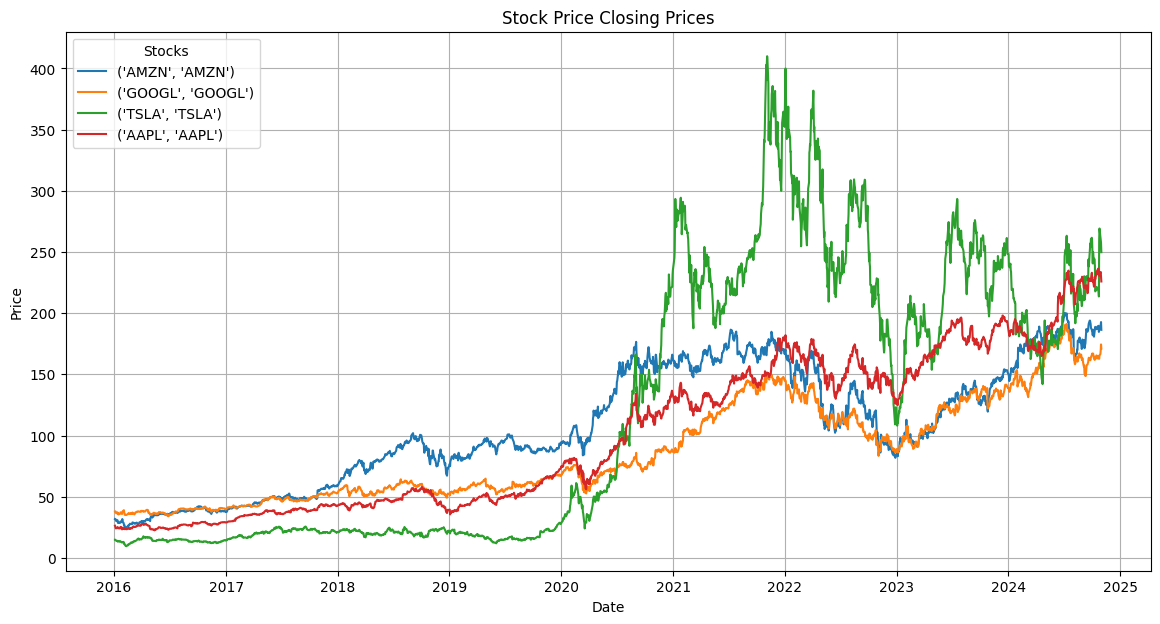

In [4]:
# Plot the data
plt.figure(figsize=(14, 7))
for column in combined_data.columns:
    plt.plot(combined_data.index, combined_data[column], label=column)

# Add labels
plt.title("Stock Price Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(title="Stocks", loc='upper left')
plt.grid(True)
plt.show()

#### Data Infos

In [5]:
# Data manipulation and analysis
print("=============================================")
print("Data types of the columns in the data frame:", combined_data.dtypes) # Data types of the columns
print("=============================================")
print("Shape of the data frame:", combined_data.shape) # Shape of the data frame
print("=============================================")
print("Lenght of the data:", len(combined_data)) # Length of the data
print("=============================================")
print("Checking for missing values in the data:\n", combined_data.isnull().sum()) # Checking for missing values
print("=============================================")
combined_data.describe() # Summary statistics of the data

Data types of the columns in the data frame:        Ticker
AMZN   AMZN      float64
GOOGL  GOOGL     float64
TSLA   TSLA      float64
AAPL   AAPL      float64
dtype: object
Shape of the data frame: (2223, 4)
Lenght of the data: 2223
Checking for missing values in the data:
        Ticker
AMZN   AMZN      0
GOOGL  GOOGL     0
TSLA   TSLA      0
AAPL   AAPL      0
dtype: int64


,AMZN,GOOGL,TSLA,AAPL
Ticker,AMZN,GOOGL,TSLA,AAPL
count,2223.000000,2223.000000,2223.000000,2223.000000
mean,107.908992,86.776827,122.395469,101.258318
std,48.543233,40.809819,111.072684,62.601656
min,24.103500,34.056999,9.578000,22.584999
25%,73.481251,52.864750,19.829667,42.772501
50%,98.699997,72.525002,59.960667,81.302498
75%,155.427002,122.266750,223.683334,155.830002
max,200.000000,191.179993,409.970001,236.479996


#### Data PreProcessing

In [6]:
# Scale data between 0 and 1 for LSTM
# Scaling using for more effective training
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(combined_data) # Fit and transform the data
scaled_df = pd.DataFrame(scaled_data, index=combined_data.index, columns=combined_data.columns) # Convert the scaled data to a data frame

# Split the data into train, test and validation sets
train_size = int(len(scaled_df) * 0.7) # 70% train data
test_size = int(len(scaled_df) * 0.2) # 20% test data
train_data = scaled_df.iloc[:train_size] # Train data
test_data = scaled_df.iloc[train_size:train_size + test_size] 
val_data = scaled_df.iloc[train_size + test_size:]

# Create time series data
window_size = 60  # 60 days
def create_time_series(data, window_size): 
    x, y = [], []
    for i in range(len(data) - window_size):
        x.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(x), np.array(y)

# Create time series data for train, test and validation sets
x_train, y_train = create_time_series(train_data.values, window_size) 
x_test, y_test = create_time_series(test_data.values, window_size)
x_val, y_val = create_time_series(val_data.values, window_size)

#### Creating The Nerual Network using LSTM 

In [7]:
# Print the shapes of the data 
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(window_size, x_train.shape[2])), # Input layer
    Dropout(0.3), # Dropout using for reducing overfitting
    LSTM(100), 
    Dropout(0.3),
    Dense(y_train.shape[1])  # Output layer
])

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5) 

# Stop training when a monitored quantity has stopped improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
start = time.time()
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100,  
    batch_size=64,
    callbacks=[reduce_lr, early_stopping] 
)
end = time.time()
time_taken = end - start

c:\Users\ErenElagz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - loss: 0.0392 - val_loss: 0.0242 - learning_rate: 0.0010
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.0070 - val_loss: 0.0325 - learning_rate: 0.0010
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0044 - val_loss: 0.0307 - learning_rate: 0.0010
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0034 - val_loss: 0.0186 - learning_rate: 0.0010
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0032 - val_loss: 0.0180 - learning_rate: 0.0010
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0028 - val_loss: 0.0142 - learning_rate: 0.0010
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0030 - val_loss: 0.0096 - learning_rate: 0.0010
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0028 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0025 - val_loss: 0.0071 - learning_rate: 0.0010
E

#### Model Data

In [8]:
model.summary() # Display the model summary
print("Time taken to train the model:", time_taken, "seconds") # Time taken to train the model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        42,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 368,414 (1.41 MB)

 Trainable params: 122,804 (479.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 245,610 (959.42 KB)

Time taken to train the model: 75.9981861114502 seconds


##### Plotting the Train and Test Scores

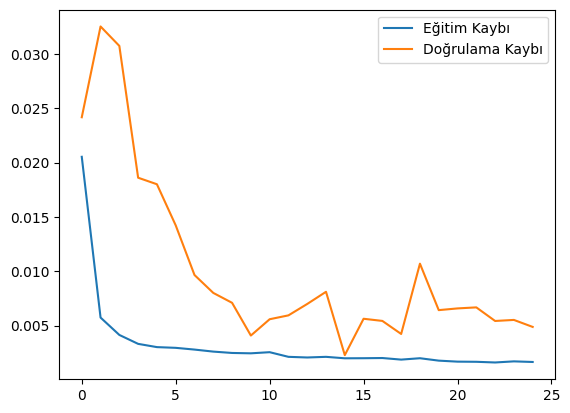

In [9]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.legend()
plt.show()

##### Comparing the Train and Test Scores

In [10]:
# Train and test losses
train_loss = history.history['loss'][-1]  # Final loss after training
test_loss = model.evaluate(x_test, y_test) # Loss on test data

# Print the final train and test losses
print(f"=============================================")
print(f"Train Loss: {train_loss}")
print(f"Test Loss: {test_loss}")
print(f"=============================================")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0020
Train Loss: 0.0016439617611467838
Test Loss: 0.0017321765189990401


##### Evaulating the Model
F1 score and accuracy are not suitable methods for regression models.For regression models, metrics like MSE, MAPE, and RMSE provide better insights.

In [14]:
# Predictions
y_pred = model.predict(x_test)

# Inverse transform the data
y_test_actual = scaler.inverse_transform(y_test)  # Inverse transform the test data
y_pred_actual = scaler.inverse_transform(y_pred)  # Inverse transform the predictions

# Plot the predictions
mse = mean_squared_error(y_test_actual, y_pred_actual) 
rmse = root_mean_squared_error(y_test_actual, y_pred_actual) 
mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual) * 100
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

# Print the error metrics
print(f"=============================================")
print(f"Mean Squared Error: {mse:.2f}") # Mean Squared Error
print(f"Root Mean Squared Error: {rmse:.2f}") # Root Mean Squared Error
print(f"=============================================")
print(f"Mean Absolute Error: {mae:.2f} $ Gunluk Sapma Miktari") # Mean Absolute Error
print(f"=============================================")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%") # Mean Absolute Percentage Error
print(f"! A MAPE below 10-20% is generally considered good for financial predictions.")
print(f"=============================================")
print(f"R^2 Score: {r2:.2f}") # R^2 Score
print(f"=============================================")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Mean Squared Error: 113.78
Root Mean Squared Error: 9.75
Mean Absolute Error: 7.82 $ Gunluk Sapma Miktari
Mean Absolute Percentage Error (MAPE): 5.23%
! A MAPE below 10-20% is generally considered good for financial predictions.
R^2 Score: 0.83


##### Prediction Table 

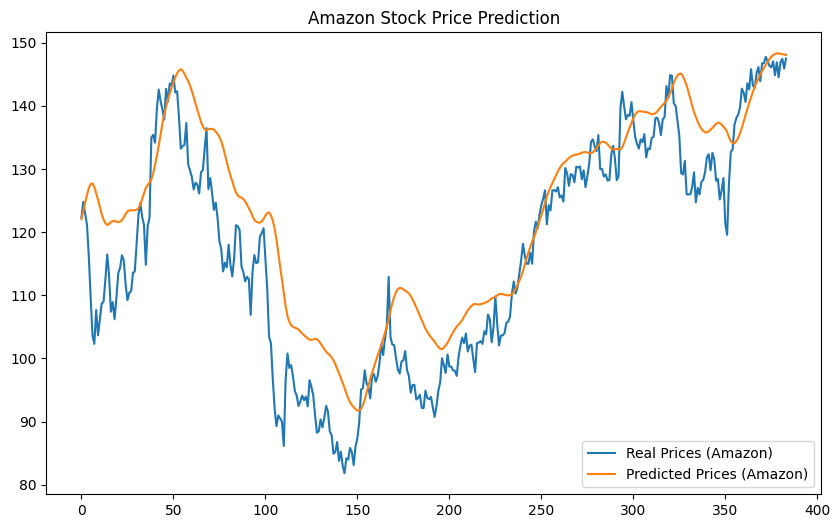

In [12]:
# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual[:, 0], label="Real Prices (Amazon)")
plt.plot(y_pred_actual[:, 0], label="Predicted Prices (Amazon)")
plt.legend()
plt.title("Amazon Stock Price Prediction")  
plt.show()

##### Evaulating the Model
F1 score and accuracy are not suitable methods for regression models.For regression models, metrics like MSE, MAPE, and RMSE provide better insights.

In [13]:
# Plot the predictions
y_test_class = (y_test_actual[1:] > y_test_actual[:-1]).astype(int)                                                                                                                                                                                                                                                                                                                   
y_pred_class = (y_pred_actual[1:] > y_pred_actual[:-1]).astype(int)

# Classification metrics
accuracy = accuracy_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class, average='weighted', zero_division=0)
recall = recall_score(y_test_class, y_pred_class, average='micro', zero_division=0)
f1 = f1_score(y_test_class, y_pred_class,average='micro', zero_division=0)

# Print the classification metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.15
Precision: 0.51
Recall: 0.57
F1 Score: 0.54
